In [1]:
!pip install tellurium &> /dev/null 
!pip install lmfit &> /dev/null

import tellurium as te              
import numpy as np
import matplotlib.pyplot as plt
import lmfit
from lmfit import minimize, Parameters
import pandas as pd
from scipy.optimize import shgo, dual_annealing, differential_evolution, least_squares
%matplotlib inline


**Model.**

---



PInh_cis <-> PInh_trans  cis->trans by blue light, trans -> cis by uv light. Here, in most cases Trans is a stronger inhibitor (smaller Ki) than Cis. Trans is always a thermal state

Experimental conditions:
Flowrate = 1200 uL/h, reactor volume = 200 uL.
AMC flowrate in the T-junction = 200 uL/h.

Km = 85 uM, kcat = 128 1/s


$PI\_trans\xrightarrow{k\_trans\_cis}PI\_cis$

$PI\_cis\xrightarrow{k\_cis\_trans}PI\_trans$



In [2]:
model_string = '''
model ultransesitivity
  // Reactions:
  #Chemical reactions
  R1: PInh_cis  -> PInh_trans; k_blue * blue_light * PInh_cis - k_UV * uv_light * PInh_trans;
  R2: Sub -> AMC; V;
  
  # Flow terms
  F1: -> PInh_cis; k_flow* (PInh_cis_inflow - PInh_cis);
  F2: -> PInh_trans; k_flow* (PInh_trans_inflow - PInh_trans);
  F3: -> Sub; k_flow*(Sub_inflow - Sub);
  F4: -> AMC; - k_flow*AMC;

  // Species initializations:
  PInh_cis = 0; PInh_trans =0; Sub=0; AMC=0;
  PInh_cis_inflow=0; PInh_trans_inflow=0; Sub_inflow=0; 
  Cr0=0;

  // Enzymatic rate
  V:=k_cat*Cr0 * (Sub/KM_Sub) / (1 + Sub/KM_Sub + PInh_cis/Ki_cis + PInh_trans/Ki_trans);

  // Rate constants:
  KM_Sub = 85e-6;#uM
  k_cat = 1e3;   # 1
  k_blue = 100; #1/min
  k_UV = 3.3; #1/min

  Ki_cis = 200e-6; #uM, determined experimentally in this work.
  Ki_trans = 12e-6;#uM, determined experimentally in this work.
  k_flow = 0.1; #1/min

  #Boolean values
  blue_light = 0; uv_light = 0;
   
end'''
        
model = te.loada(model_string)
model_amc = te.loada(model_string)


**Helper functions.**

---
Helper functions that are used later in the code.


In [3]:
def reset_model_update_parameters(model, parameters):
  '''First, resets all concentrations and rate constants to the default values specified in the model string.
  Then updates concentrations and rate constants according to the values provided in parameters.
  '''
  model.resetAll()
  for compound, concentration in parameters.items():
    model[compound] = concentration


def generate_light_sequence(time_start = 60, total_time = 150, light_sequence = ['uv', 'blue'], time_sequence = [1, 1]):
  '''Creates a DataFrame with a boolean irradiation sequence that will be used in a simulation.
  light_sequence - list with 'uv', 'blue' or 'off',
  time_sequence - list with time duration of each step, in minutes.
  ---
  Example:
  generate_light_sequence(20,20, ['uv','off','blue'], [10,5,15])
  Returns:
 	  duration 	uv_light 	blue_light
  0 	20 	      0 	        0
  1 	10 	      1 	        0
  2 	5 	      0 	        0
  3 	15 	      0 	        1
  4 	20 	      0 	        0
  '''
  
  #Creates boolean sequncec of uv and blue light. 
  #Boolean 0 is appended in the begining and in the end, 
  #indicating that there is no irradiation before and after the pulses.
  uv_sequence = [0] + [int(condition == 'uv') for condition in light_sequence] + [0]
  blue_sequence = [0] + [int(condition == 'blue') for condition in light_sequence] + [0]
  time_profile = [time_start] + time_sequence + [total_time - time_start - sum(time_sequence)]
  
  light_pulses_df = pd.DataFrame(data= np.transpose([time_profile, uv_sequence, blue_sequence]), columns = ['duration',  'uv_light', 'blue_light'])
  return light_pulses_df


def simulate_several_pulses(model, light_pulses_sequence):
  '''Simulates the timetrace of the model using
  input DataFrame with the light sequnce. Return DataFrame as an output.'''
  time_start = 0
  time_end = 0
  simulation_results = []

  #Iterates over each conditions in the DataFrame with the light sequence
  for idx in light_pulses_sequence.index:
    #Read light conditions
    pulse_duration  = light_pulses_sequence.loc[idx,'duration']
    model['uv_light'] = light_pulses_sequence.loc[idx,'uv_light']
    model['blue_light'] = light_pulses_sequence.loc[idx,'blue_light']
    
    #Simulation itself
    time_end += pulse_duration
    result = model.simulate(time_start,time_end,int((time_end-time_start)*5) + 5)
    time_start += pulse_duration

    #Save the simulation result to a list of DataFrames
    result = pd.DataFrame(data=result.view(), columns = result.colnames)  
    simulation_results.append(result)

  #Concatenate the list of DataFrame and produce the output 
  final_result = pd.concat(simulation_results)
  final_result = final_result.set_index('time')
  return final_result


def get_time_in_minutes(timepoint):
  '''Helper function for the resample_df function.'''
  return (timepoint.day-1)*24*60+timepoint.hour*60+timepoint.minute

def resample_df(input_df, resample_time):
  '''Resamples the timetrace to make equal time steps '''
  #Make a copy here to prevent modification of the original dataframe
  df = input_df.copy() 
  timearray = pd.to_datetime({'year': [2000] * len(df.index),
                'month': [1] * len(df.index),
                'day': [1] * len(df.index),
                'minutes':list(df.index)})
  df.index = timearray
  output_df = df.resample(str(resample_time) + 'T').mean().interpolate()
  output_df.index = [get_time_in_minutes(idx) for idx in output_df.index]

  return output_df


def get_fluorescence(result, Substrate = 40e-6):
  '''Experimentally substrate is added after the flow reactor in a microfluidic T-junction.
  This functions calculates the amount of AMC produced in the T-junction based on concentration of cis and trans inhibitors.
  '''
  amc_output = []

  #Resampling of the input model

  #Simulates the amount of AMC produced for each point in the resampled DataFrame.
  resampled_df = resample_df(result, 2.5)

  for time, concentrations in resampled_df.iterrows():
      conc_dict = concentrations.to_dict()
      reset_model_update_parameters(model_amc, conc_dict)
      model_amc['k_flow'] = 0
      model_amc['Cr0'] = model['Cr0']
      model_amc['Sub'] = Substrate
      model_amc['Sub_inflow'] = Substrate

      reaction_with_amc = model_amc.simulate(0,5,3)

      amc_conc = reaction_with_amc['[AMC]'][-1]
      amc_output.append(amc_conc)

  amc = pd.DataFrame(index = resampled_df.index, data = amc_output,columns = ['[AMC]'])

  return amc


def normalize(data):
  '''Normalizes the data by subtracting the minimal value and dividing by the maximum value.'''
  subtracted_data = data - min(data)
  norm_data = subtracted_data / max(subtracted_data)
  return norm_data

**Simulations.**

---



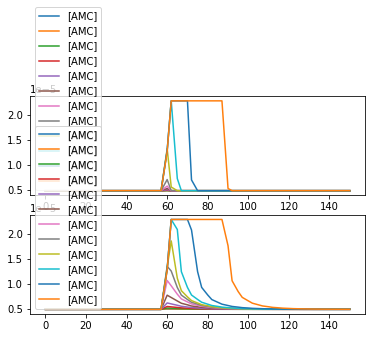

In [4]:
parameters = {'Cr0': 40e-9, 'PInh_trans_inflow': 200e-6, 'Sub_inflow': 0, 'PInh_trans': 200e-6, 'Sub': 0, 'k_flow' : 0.1}

time_range = np.logspace(np.log10(0.005), np.log10(30),12)

amc_max_uv_blue = np.zeros_like(time_range)
amc_max_uv = np.zeros_like(time_range)

ax1=plt.subplot(2, 1,1)
ax2=plt.subplot(2, 1,2)

for i, time_point in enumerate(time_range):
  reset_model_update_parameters(model, parameters)
  light_pulses_df = generate_light_sequence(light_sequence = ['uv', 'blue'], time_sequence = [time_point, 15/60])
  result = simulate_several_pulses(model, light_pulses_df)
  #result.plot(y='[AMC]', ax=ax1, label='{:.2f}'.format(time_point))
  amc = get_fluorescence(result)
  amc.plot(ax=ax1)
  amc_max_uv_blue[i] = amc['[AMC]'].max()

  reset_model_update_parameters(model, parameters)
  light_pulses_df = generate_light_sequence(light_sequence = ['uv', 'off'], time_sequence = [time_point, 15/60])
  result = simulate_several_pulses(model, light_pulses_df)
  amc = get_fluorescence(result)
  amc.plot(ax=ax2)
  amc_max_uv[i] = amc['[AMC]'].max()


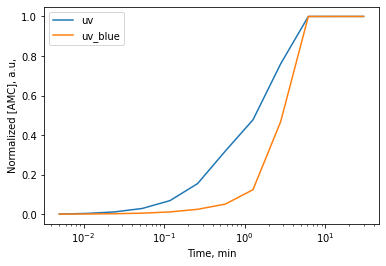

In [5]:
plt.figure()
plt.semilogx(time_range, normalize(amc_max_uv), label='uv')
plt.semilogx(time_range, normalize(amc_max_uv_blue), label='uv_blue')
plt.xlabel('Time, min')
plt.ylabel('Normalized [AMC], a.u,')
plt.legend()
plt.savefig('model_output.png')

Save output

In [6]:
# output_data = pd.DataFrame (index = time_range, data = np.array([norm(amc_max_uv), normalize(amc_max_uv_blue)]).transpose(), columns = ['uv_pulses','uv_blue_pulses'])
# output_data.to_excel('model_output.xlsx')

**Experimental Data**

---



In [7]:
#Figure 4a
exp_time = [0.01667, 0.03333, 0.08333, 0.16666, 0.25, 0.5, 1, 2, 3, 4, 5, 7.5, 10, 30]
exp_uv = [0,0.00169,0.03105,0.08073,0.13549,0.25179,0.4443,0.56191,0.68931,0.78133,0.85849,0.97892,1.00489,1]
exp_uv_blue = [0,-0.000395726,0.000395726,0.000989315,-0.000989315,-0.000197863,0.000395726,0.00791,0.05481,0.14306,0.23011,0.80748,0.95548,1]

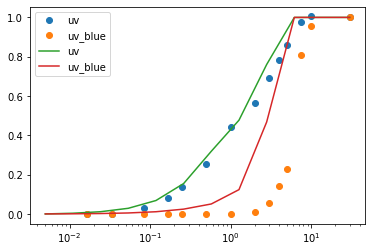

In [8]:
plt.figure()
plt.semilogx(exp_time, exp_uv, 'o',label='uv' )
plt.semilogx(exp_time, exp_uv_blue, 'o',label='uv_blue')
plt.semilogx(time_range, normalize(amc_max_uv), label='uv')
plt.semilogx(time_range, normalize(amc_max_uv_blue), label='uv_blue')
plt.legend()

**Parameter fitting.** 

---


The goal is to obtain value for k_uv and k_blue by fitting model to the experimental data.

In [9]:
def get_sigmoid_with_varied_pulse(model, parameters, time_points, light_sequence, blue_duration = 15/60, normalize_output = True):
  '''Returns data for two AMC-pulse time curves (uv-off and uv-blue sequences.'''
  if len(light_sequence) > 2:
    print('Warning: the function is not adapted to be used with len(ligth_sequence)>2. Please modify the function')
    return 'Error'
    
  amc_max = np.zeros_like(time_points)
  for i, time_point in enumerate(time_points):
    reset_model_update_parameters(model, parameters)
    light_pulses = generate_light_sequence(light_sequence = light_sequence, time_sequence = [time_point, blue_duration])
    result = simulate_several_pulses(model, light_pulses)
    amc = get_fluorescence(result)
    amc_max[i] = amc['[AMC]'].max()
  
  if normalize_output == True:
    return normalize(amc_max)
  else:
    return amc_max

In [10]:
def residual(fitting_parameters, model, exp_parameters, exp_time, exp_uv ,exp_uv_blue, *args):
  '''Difference between model and data.'''
  print(fitting_parameters)
  parameters = exp_parameters
  for k, v in fitting_parameters.items():
    parameters.update({k:v.value})
  amc_simulated_uv = get_sigmoid_with_varied_pulse(model, parameters, exp_time, ['uv', 'off'])
  amc_simulated_uv_blue = get_sigmoid_with_varied_pulse(model, parameters, exp_time, ['uv', 'blue'])

  residual_uv = 10*(amc_simulated_uv -  exp_uv)
  residual_uv_blue = amc_simulated_uv_blue - exp_uv_blue

  residual = np.concatenate((residual_uv, residual_uv_blue))

  print(sum(abs(residual)))

  return residual


In [11]:
fitting_parameters= Parameters()
fitting_parameters.add('k_blue', value=1,min=0.01, max=100)
fitting_parameters.add('k_UV', value=1, min=0.01, max=100)
exp_parameters = {'Cr0': 40e-9, 'PInh_trans_inflow': 200e-6, 'Sub_inflow': 0, 'PInh_trans': 200e-6, 'Sub': 0, 'k_flow' : 0.1}

fit_result = minimize(residual, fitting_parameters, args=(model, exp_parameters ,exp_time, exp_uv, exp_uv_blue) ,  method='differential_evolution', tol = 1e-1)



Parameters([('k_blue', <Parameter 'k_blue', value=95.70474179305488, bounds=[0.01:100]>), ('k_UV', <Parameter 'k_UV', value=95.8645988083191, bounds=[0.01:100]>)])
18.30873834104265
Parameters([('k_blue', <Parameter 'k_blue', value=0.07199298810109357, bounds=[0.01:100]>), ('k_UV', <Parameter 'k_UV', value=70.67750467688728, bounds=[0.01:100]>)])
23.499428278792916
Parameters([('k_blue', <Parameter 'k_blue', value=53.5602712852163, bounds=[0.01:100]>), ('k_UV', <Parameter 'k_UV', value=7.479186753299195, bounds=[0.01:100]>)])
13.507689314538922
Parameters([('k_blue', <Parameter 'k_blue', value=2.2892081916704954, bounds=[0.01:100]>), ('k_UV', <Parameter 'k_UV', value=0.014627051200465153, bounds=[0.01:100]>)])
34.967299962064
Parameters([('k_blue', <Parameter 'k_blue', value=16.197050383945072, bounds=[0.01:100]>), ('k_UV', <Parameter 'k_UV', value=10.197241556507183, bounds=[0.01:100]>)])
16.091879564437964
Parameters([('k_blue', <Parameter 'k_blue', value=5.180023437328835, bounds=[0

In [12]:
fit_result

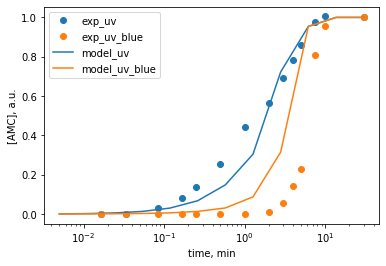

In [13]:
time_range = np.logspace(np.log10(0.005), np.log10(30),12)
parameters = {'Cr0': 40e-9, 'PInh_trans_inflow': 200e-6, 'Sub_inflow': 0, 'PInh_trans': 200e-6, 'Sub': 0, 'k_flow' : 0.1,
              'k_blue':100, 'k_UV': 1.2}

amc_simulated_uv = get_sigmoid_with_varied_pulse(model, parameters, time_range, ['uv', 'off'])
amc_simulated_uv_blue = get_sigmoid_with_varied_pulse(model, parameters, time_range, ['uv', 'blue'])

plt.figure()
plt.semilogx(exp_time, exp_uv, 'o',label='exp_uv' )
plt.semilogx(exp_time, exp_uv_blue, 'o',label='exp_uv_blue')
plt.semilogx(time_range, amc_simulated_uv, label='model_uv', color = 'tab:blue')
plt.semilogx(time_range, amc_simulated_uv_blue, label='model_uv_blue', color = 'tab:orange')
plt.xlabel('time, min')
plt.ylabel('[AMC], a.u.')
plt.legend()

**An interactive plot to explore the influence of rate constants.**

---



Please note that updating the graph takes 1-2 s.

In [14]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def interactive_sigmoid(k_UV = 1.7, k_blue = 50, k_flow = 0.1):
  parameters = {'Cr0': 40e-9, 'PInh_trans_inflow': 600e-6, 'Sub_inflow': 0, 'PInh_trans': 600e-6, 'Sub': 0, 'k_flow' : k_flow,
                'k_UV': k_UV, 'k_blue': k_blue}
  time_range = np.logspace(np.log10(0.005), np.log10(30),12)
  amc_simulated_uv = get_sigmoid_with_varied_pulse(model, parameters, time_range, ['uv', 'off'])
  amc_simulated_uv_blue = get_sigmoid_with_varied_pulse(model, parameters, time_range, ['uv', 'blue'])

  plt.semilogx(time_range, amc_simulated_uv, label = 'uv')
  plt.semilogx(time_range, amc_simulated_uv_blue, label = 'uv_blue')
  plt.xlabel('time, min')
  plt.ylabel('[AMC], a.u.')
  plt.legend()
  plt.show()

interactive_plot = interactive(interactive_sigmoid, 
                               k_UV=widgets.FloatLogSlider(
                              value=3.3,
                              base=10,
                              min=-1,
                              max=2, 
                              step=0.05, 
                              description='k_UV'), 
                              k_blue=widgets.FloatLogSlider(
                              value=100,
                              base=10,
                              min=-1,
                              max=2, 
                              step=0.05, 
                              description='k_blue'), 
                              k_flow = (0.1, 1))

interactive_plot

interactive(children=(FloatLogSlider(value=3.3, description='k_UV', max=2.0, min=-1.0, step=0.05), FloatLogSli…

**Some supplementary graphs.**

---



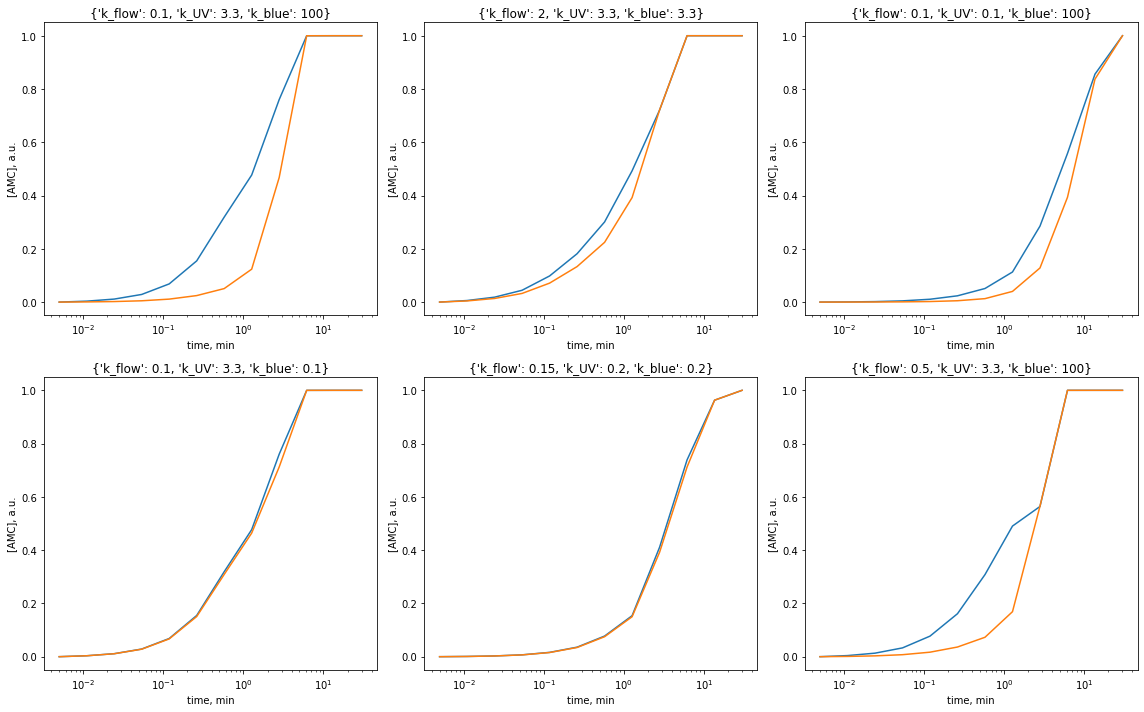

In [15]:
parameters_dict = [{'k_flow' : 0.1,'k_UV': 3.3, 'k_blue': 100},
                  {'k_flow' : 2,'k_UV': 3.3, 'k_blue': 3.3},
                  {'k_flow' : 0.1,'k_UV': 0.1, 'k_blue': 100},
                  {'k_flow' : 0.1,'k_UV': 3.3, 'k_blue': 0.1},
                  {'k_flow' : 0.15,'k_UV': 0.2, 'k_blue': 0.2},
                  {'k_flow' : 0.5,'k_UV': 3.3, 'k_blue': 100}]

time_range = np.logspace(np.log10(0.005), np.log10(30),12)
concentrations = {'Cr0': 40e-9, 'PInh_trans_inflow': 200e-6, 'Sub_inflow': 0, 'PInh_trans': 200e-6, 'Sub': 0}


fig, axs = plt.subplots( 2, 3,figsize = (16,10))
for i, ax in enumerate(fig.axes):

    parameters = parameters_dict[i].copy()
    parameters.update(concentrations)
    amc_simulated_uv = get_sigmoid_with_varied_pulse(model, parameters, time_range, ['uv', 'off'])
    amc_simulated_uv_blue = get_sigmoid_with_varied_pulse(model, parameters, time_range, ['uv', 'blue'])

    ax.semilogx(time_range, amc_simulated_uv, label = 'uv')
    ax.semilogx(time_range, amc_simulated_uv_blue, label = 'uv_blue')
    ax.set_title(parameters_dict[i])
    ax.set_xlabel('time, min')
    ax.set_ylabel('[AMC], a.u.')
plt.tight_layout()

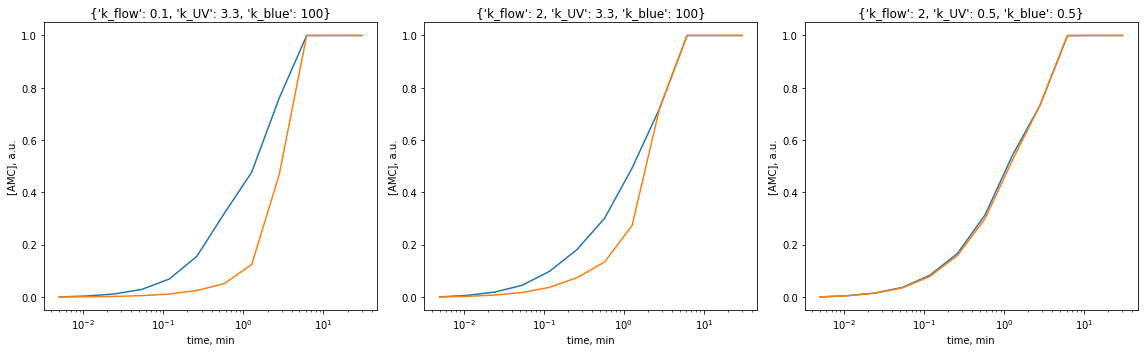

In [16]:
parameters_dict = [{'k_flow' : 0.1,'k_UV': 3.3, 'k_blue': 100},
                  {'k_flow' : 2,'k_UV': 3.3, 'k_blue': 100},
                  {'k_flow' : 2,'k_UV': 0.5, 'k_blue': 0.5}]

time_range = np.logspace(np.log10(0.005), np.log10(30),12)
concentrations = {'Cr0': 40e-9, 'PInh_trans_inflow': 200e-6, 'Sub_inflow': 0, 'PInh_trans': 200e-6, 'Sub': 0}


fig, axs = plt.subplots( 1, 3,figsize = (16,5))
for i, ax in enumerate(fig.axes):

    parameters = parameters_dict[i].copy()
    parameters.update(concentrations)
    amc_simulated_uv = get_sigmoid_with_varied_pulse(model, parameters, time_range, ['uv', 'off'])
    amc_simulated_uv_blue = get_sigmoid_with_varied_pulse(model, parameters, time_range, ['uv', 'blue'])

    ax.semilogx(time_range, amc_simulated_uv, label = 'uv')
    ax.semilogx(time_range, amc_simulated_uv_blue, label = 'uv_blue')
    ax.set_title(parameters_dict[i])
    ax.set_xlabel('time, min')
    ax.set_ylabel('[AMC], a.u.')
plt.tight_layout()
plt.savefig('varied_flowrate.png', dpi = 120)